# Comparing the impacts of random and non-random matches on the triangle plots

Per discussion with J and R March 18:  
    Request to understand the impacts of random and non-random choices on the triangle trend plots
    
### Approach:  
Choose models with both random and non-random matches; Do plots with just random, plots with just non-random and plots with both  
Models of choice: CanESM5, GISS-E2-1-G

In [92]:
%reset -f

In [93]:
%load_ext autoreload

In [94]:
%reload_ext autoreload
%autoreload 2

In [97]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict
from datetime import date

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient
from GradTrendClasses import CalcMMEGradSubset
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels, ClassifyHistModelsLite

#### Outputs

In [99]:
#______Trends and Gradients________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
trendsDirEnd = 'Trends_RNR_' + str(date.today())
gradientsDirEnd = 'Gradients_RNR_' + str(date.today())

trendsDir = pathBase + trendsDirEnd
gradientsDir = pathBase + gradientsDirEnd

#_____Plots________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
plotsEnd = 'Plots_RNR_' + str(date.today())

plotsDir = pathBase + plotsEnd

#### Inputs

In [100]:
#_____Hadley___________
obsDir = '/home/hbyrne/Research/QMDA_2023'

# inputting from a csv file
openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

#____Stats______
statsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'

#_____Gradients_____
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients2_2024-03-14'

## Reading in the trend information for the models that are random and not

In [129]:
modelList = ['CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']

# importing the match file
fileName = 'Match_data22024-03-14.csv'

os.chdir(statsDir)
matchData = pd.read_csv(fileName, index_col = 0)

# create a list of model names that are random and those that aren't
# creating a new column with the model name (note that these are all before the first _)
models = []
for modelName in list(matchData.index):
    charIndex = modelName.index('_')
    models.append(modelName[:charIndex])
    
matchData['Model'] = models
matchData.reindex(columns = ['Model', 'ScenModel', 'Assignment']);

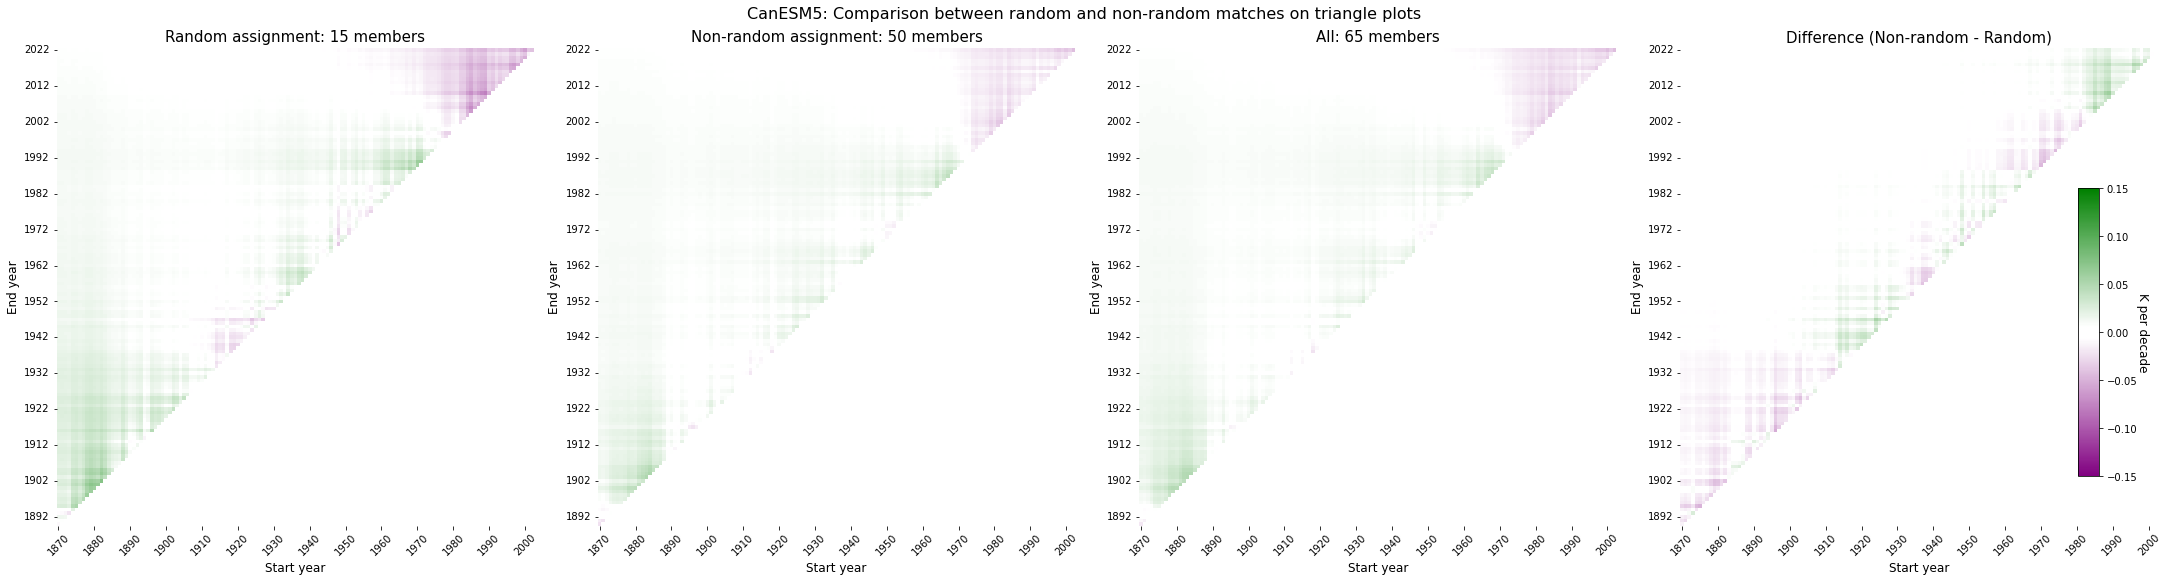

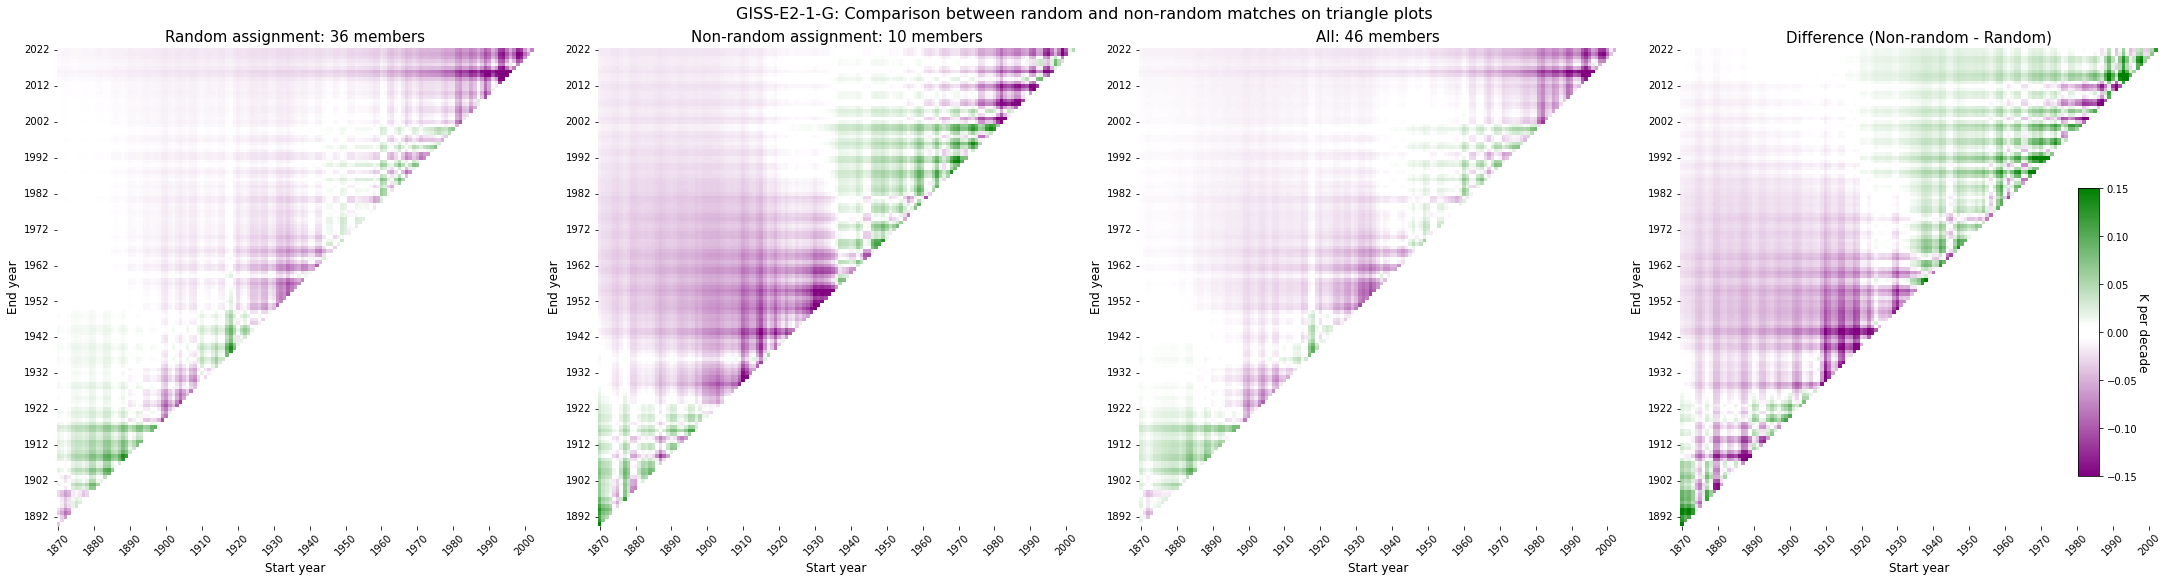

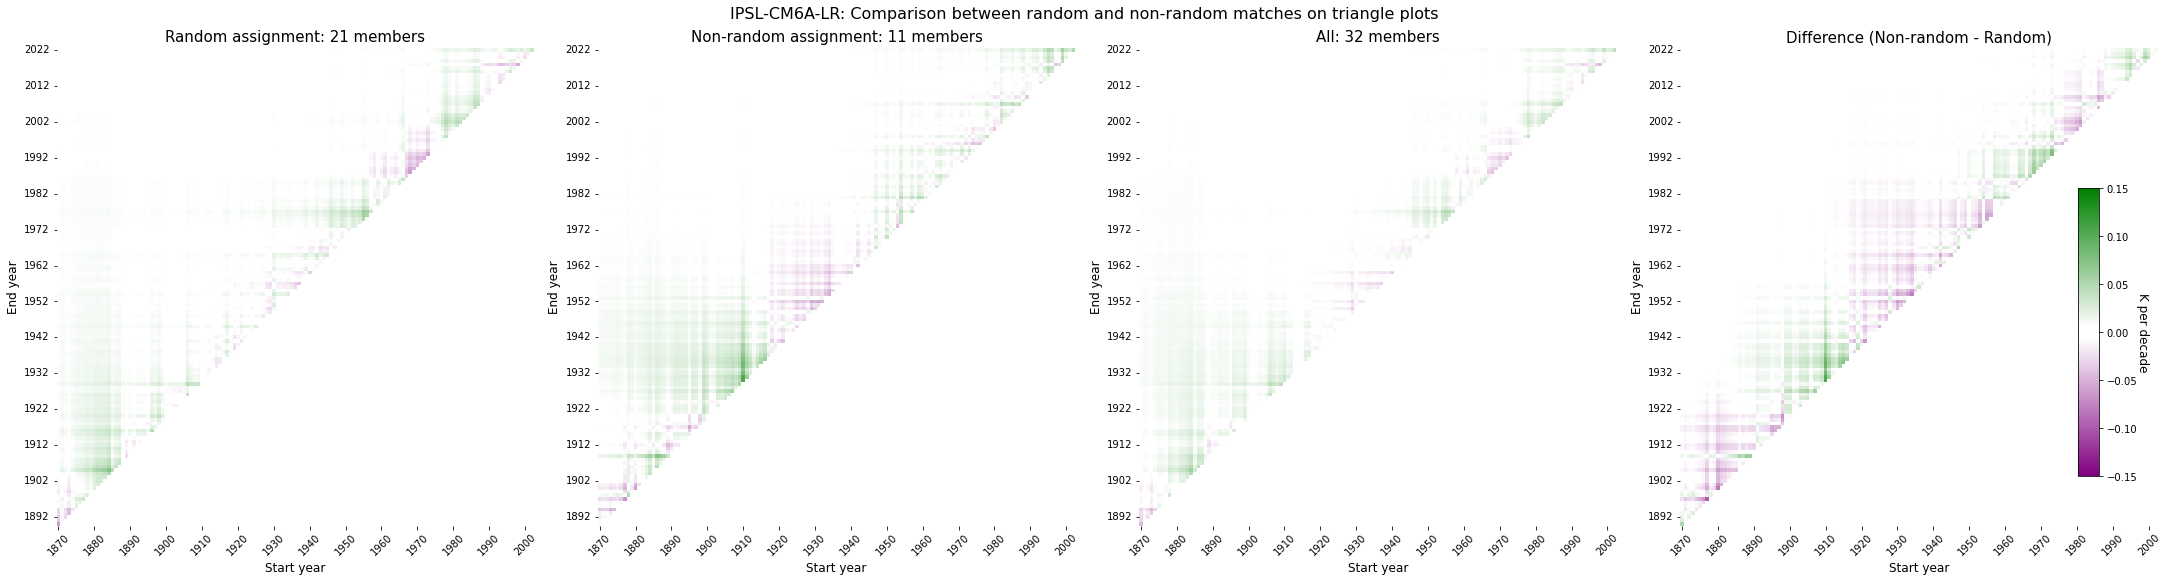

In [130]:
# Now creating lists of names of models that are separated 1) by model and 2) by random and non-random (within a dictionary)

dictRandom = defaultdict(list)
dictNonRandom = defaultdict(list)
dictAll = defaultdict(list)

for model in modelList:
    dictRandom[model].append(list(matchData[(matchData.Assignment == 'Random') & (matchData.Model == model)].index))
    dictNonRandom[model].append(list(matchData[(matchData.Assignment == 'Non-random') & (matchData.Model == model)].index))
    dictAll[model].append(list(matchData[matchData.Model == model].index))
    
dictRandom = dict(dictRandom)
dictNonRandom = dict(dictNonRandom)

# now need to import these trend files from the directory and plot them in groups; maybe best to do the ensemble mean at this point?
# idea: plot for only random, only non-random, both and the difference between that and the mean of both
# create a different figure for each model

for i, model in enumerate(modelList):
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (30,8), constrained_layout = True)
    fig.suptitle(f'{model}: Comparison between random and non-random matches on triangle plots', fontsize = 16)
    
    # plotting settings
    vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)
    
    # ____RANDOM____
    subsetList = dictRandom[model][0]
    gradientMean = CalcMMEGradSubset(gradientsDir, model, subsetList)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf
    
    # plotting
    offset = 20 # years
    trendsDfCropRandom = CropTrendsDf(trendsDf, offset)

    axes[0].set_title(f'Random assignment: {len(subsetList)} members', fontsize = 15)
    axes[0].set_aspect('equal')
    plot = sns.heatmap(trendsDfCropRandom, cmap = cmap, ax = axes[0], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axes[0].tick_params(axis = 'x', rotation = 45)
    axes[0].tick_params(axis = 'y', rotation = 0)
    axes[0].set_ylabel('End year', fontsize = 12)
    axes[0].set_xlabel('Start year', fontsize = 12)
    
    # ____NON-RANDOM____
    subsetList = dictNonRandom[model][0]
    gradientMean = CalcMMEGradSubset(gradientsDir, model, subsetList)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf
    
    # plotting
    offset = 20 # years
    trendsDfCropNonRandom = CropTrendsDf(trendsDf, offset)

    axes[1].set_title(f'Non-random assignment: {len(subsetList)} members', fontsize = 15)
    axes[1].set_aspect('equal')
    plot = sns.heatmap(trendsDfCropNonRandom, cmap = cmap, ax = axes[1], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axes[1].tick_params(axis = 'x', rotation = 45)
    axes[1].tick_params(axis = 'y', rotation = 0)
    axes[1].set_ylabel('End year', fontsize = 12)
    axes[1].set_xlabel('Start year', fontsize = 12)
    
    #____ALL_____
    subsetList = dictAll[model][0]
    gradientMean = CalcMMEGradSubset(gradientsDir, model, subsetList)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf
    
    # plotting
    offset = 20 # years
    trendsDfCrop = CropTrendsDf(trendsDf, offset)

    axes[2].set_title(f'All: {len(subsetList)} members', fontsize = 15)
    axes[2].set_aspect('equal')
    plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = axes[2], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axes[2].tick_params(axis = 'x', rotation = 45)
    axes[2].tick_params(axis = 'y', rotation = 0)
    axes[2].set_ylabel('End year', fontsize = 12)
    axes[2].set_xlabel('Start year', fontsize = 12)
    
    #____DIFFERENCE_____
    trendsDfCropDiff = trendsDfCropNonRandom - trendsDfCropRandom

    axes[3].set_title(f'Difference (Non-random - Random)', fontsize = 15)
    axes[3].set_aspect('equal')
    plot = sns.heatmap(trendsDfCropDiff, cmap = cmap, ax = axes[3], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axes[3].tick_params(axis = 'x', rotation = 45)
    axes[3].tick_params(axis = 'y', rotation = 0)
    axes[3].set_ylabel('End year', fontsize = 12)
    axes[3].set_xlabel('Start year', fontsize = 12)

    cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'RNR_Triangle'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f'{fileName}_{modelList[i]}.png')